In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("SupplyChain.csv", encoding="unicode_escape")

In [3]:
# dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [4]:
# check null value
temp = df.isnull().sum()
temp[temp > 0]

Customer Lname              8
Customer Zipcode            3
Order Zipcode          155679
Product Description    180519
dtype: int64

In [5]:
# combine firstname and lastname
df["Customer Full Name"] = df["Customer Fname"] + df["Customer Lname"]

In [6]:
# fill Customer  zipcode
df["Customer Zipcode"] = df["Customer Zipcode"].fillna(0)
df["Customer Zipcode"].isnull().sum()

0

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# correlation between features
data = df

In [8]:
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])

In [9]:
data['order date (DateOrders)'].max()

Timestamp('2018-01-31 23:38:00')

In [10]:
import datetime
present = datetime.datetime(2018, 2, 1, 0, 0)
present

datetime.datetime(2018, 2, 1, 0, 0)

In [11]:
tmp = pd.DatetimeIndex(data["order date (DateOrders)"])

data["order_year"] = tmp.year
data["order_month"] = tmp.month
data["order_week_day"] = tmp.weekday
data["order_hour"] = tmp.hour
data["order_month_year"] = tmp.to_period('M')

data[["order_year", "order_month", "order_week_day", "order_hour", "order_month_year"]]

,order_year,order_month,order_week_day,order_hour,order_month_year
0,2018,1,2,22,2018-01
1,2018,1,5,12,2018-01
2,2018,1,5,12,2018-01
3,2018,1,5,11,2018-01
4,2018,1,5,11,2018-01
...,...,...,...,...,...
180514,2016,1,5,3,2016-01
180515,2016,1,5,1,2016-01
180516,2016,1,4,21,2016-01
180517,2016,1,4,20,2016-01


In [12]:
# compute rfm 
customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, \
                                                      'Order Id': lambda x: len(x), 'Sales': lambda x: x.sum()})
customer_seg

,order date (DateOrders),Order Id,Sales
Order Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


In [18]:
# divide rfm to quantile
quantiles = customer_seg.quantile(q=[0.25, 0.5, 0.75])
quantiles

,R_Value,F_Value,M_Value
0.25,75.0,1.0,293.040008
0.50,159.0,7.0,1499.825033
0.75,307.0,15.0,2915.880065


In [19]:
quantiles = quantiles.to_dict()
quantiles

{'R_Value': {0.25: 75.0, 0.5: 159.0, 0.75: 307.0},
 'F_Value': {0.25: 1.0, 0.5: 7.0, 0.75: 15.0},
 'M_Value': {0.25: 293.0400085, 0.5: 1499.82503324, 0.75: 2915.8800654175}}

In [20]:
def R_Score(a, b, c):
    if a <= c[b][0.25]:
        return 4
    if a <= c[b][0.5]:
        return 3
    if a <= c[b][0.75]:
        return 2
    return 1

def FM_Score(a, b, c):
    if a <= c[b][0.25]:
        return 1
    if a <= c[b][0.5]:
        return 2
    if a <= c[b][0.75]:
        return 3
    return 4

In [21]:
# change field name to R_Value, F_Value, M_Value
customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 'Order Id': 'F_Value', 'Sales': 'M_Value'}, inplace=True)

In [22]:
# create R_Score, R_Value -> [1, 4]
customer_seg['R_Score'] = customer_seg['R_Value'].apply(R_Score, args=('R_Value', quantiles))
customer_seg['F_Score'] = customer_seg['F_Value'].apply(FM_Score, args=('F_Value', quantiles))
customer_seg['M_Score'] = customer_seg['M_Value'].apply(FM_Score, args=('M_Value', quantiles))

In [23]:
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,792,1,499.950012,1,1,2
2,136,10,1819.730034,3,3,3
3,229,18,3537.680094,2,4,4
4,380,14,1719.630030,1,3,3
5,457,7,1274.750023,1,2,2
...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1
20754,0,1,215.820007,4,1,1
20755,0,1,327.750000,4,1,2


In [24]:
# compute rfm
def RFM_User(df):
    if df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '重要价值用户'
    if df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '重要发展用户'
    if df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '重要保持用户'
    if df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '重要挽留用户'
    
    if df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '一般价值用户'
    if df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '一般发展用户'
    if df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '一般保持用户'
    if df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '一般挽留用户'

In [25]:
customer_seg['Customer_Segmentation'] = customer_seg.apply(RFM_User, axis=1)

In [26]:
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,Customer_Segmentation
Order Customer Id,,,,,,,
1,792,1,499.950012,1,1,2,一般挽留用户
2,136,10,1819.730034,3,3,3,重要价值用户
3,229,18,3537.680094,2,4,4,重要保持用户
4,380,14,1719.630030,1,3,3,重要保持用户
5,457,7,1274.750023,1,2,2,一般挽留用户
...,...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1,一般发展用户
20754,0,1,215.820007,4,1,1,一般发展用户
20755,0,1,327.750000,4,1,2,一般发展用户


In [27]:
data['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

In [28]:
pay_type1 = data[data['Type'] == 'DEBIT']
pay_type2 = data[data['Type'] == 'TRANSFER']
pay_type3 = data[data['Type'] == 'PAYMENT']
pay_type4 = data[data['Type'] == 'CASH']


In [29]:
count1 = pay_type1['Order Region'].value_counts()
count2 = pay_type2['Order Region'].value_counts()
count3 = pay_type3['Order Region'].value_counts()
count4 = pay_type4['Order Region'].value_counts()

region_num = len(count1)

([<matplotlib.axis.XTick at 0x7f8ed57976d0>,
 <a list of 23 Text xticklabel objects>)

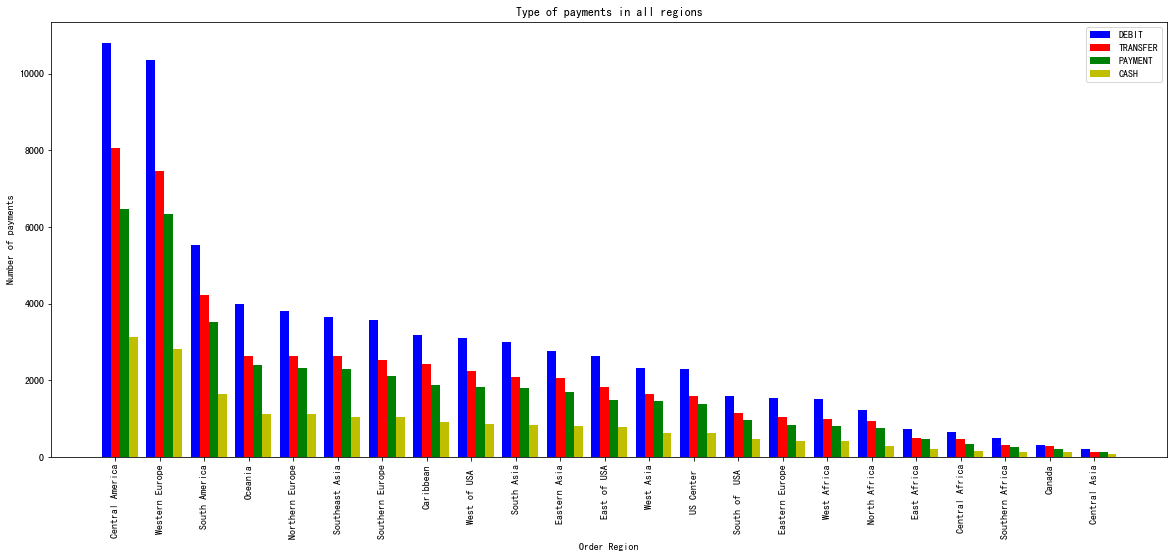

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
index = np.arange(region_num)
bar_width = 0.2
type1 = plt.bar(index, count1, bar_width, color='b', label='DEBIT')
type2 = plt.bar(index + bar_width, count2, bar_width, color='r', label='TRANSFER')
type3 = plt.bar(index + bar_width*2, count3, bar_width, color='g', label='PAYMENT')
type4 = plt.bar(index + bar_width*3, count4, bar_width, color='y', label='CASH')
plt.xlabel('Order Region')
plt.ylabel('Number of payments')
plt.title('Type of payments in all regions')
plt.legend()
names = data['Order Region'].value_counts().keys()
plt.xticks(index+bar_width, names, rotation='vertical')

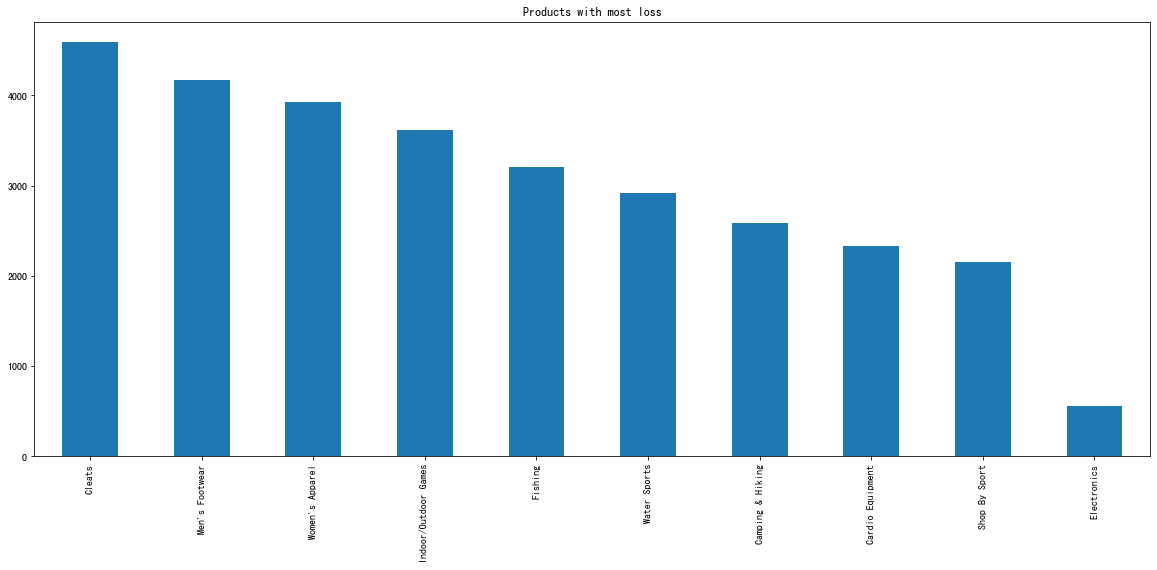

In [31]:
loss = data[data['Benefit per order'] < 0]

loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title='Products with most loss')

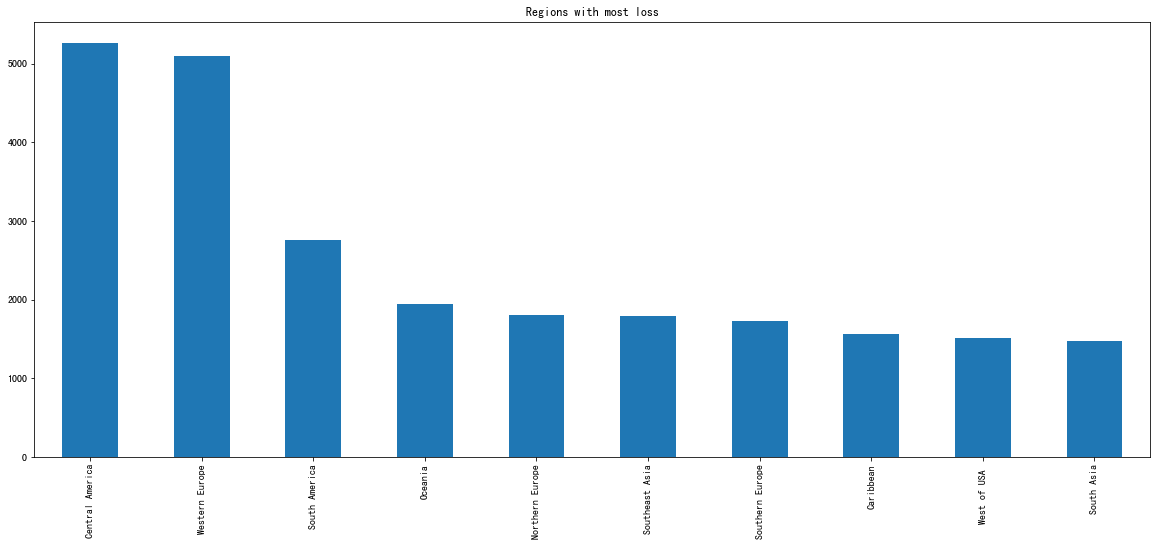

In [32]:
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title='Regions with most loss')

In [33]:
print('总损失', loss['Benefit per order'].sum())

总损失 -3883547.345768667


In [34]:
data['Order Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

In [35]:
# 负收益，可能是欺诈交易，来自于那种交付方式
data[data['Order Status'] == 'SUSPECTED_FRAUD']['Type'].value_counts()

TRANSFER    4062
Name: Type, dtype: int64

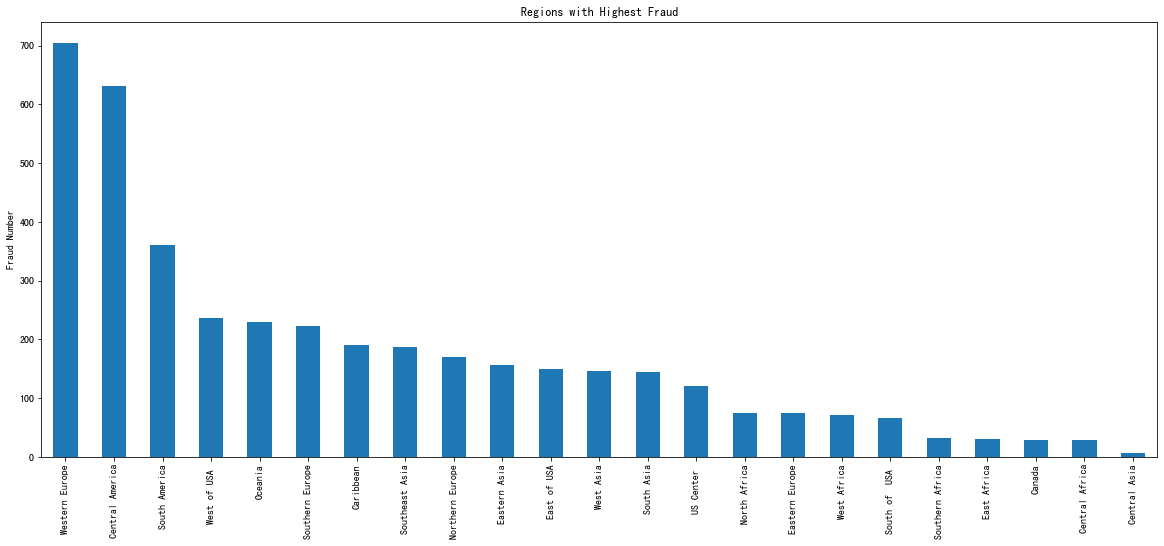

In [36]:
high_fraud = data[data['Order Status'] == 'SUSPECTED_FRAUD']
high_fraud['Order Region'].value_counts().plot.bar(figsize=(20, 8))
plt.title('Regions with Highest Fraud')
plt.ylabel('Fraud Number')
plt.show()

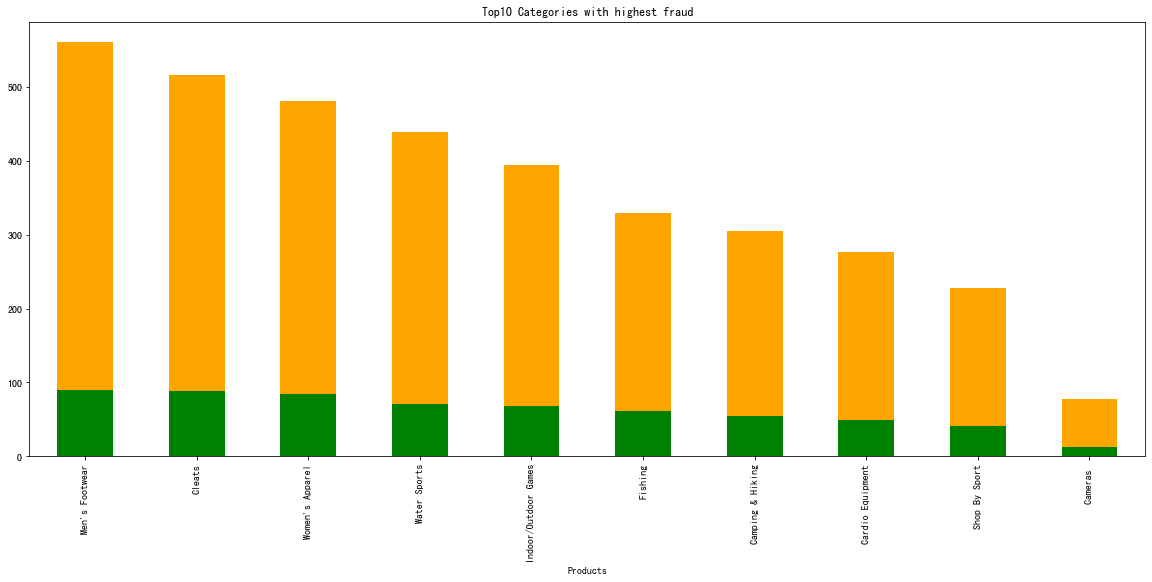

In [37]:
# Western Europe 地区欺诈交易最多，将一个bar分成两个部分
high_fraud_total = data[data['Order Status'] == 'SUSPECTED_FRAUD']
high_fraud_we = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Order Region'] == 'Western Europe')]

fraud1 = high_fraud_total['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title='Fraud Category', color='orange')
fraud2 = high_fraud_we['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title='Fraud Category in Western Europe', color='g')
plt.title('Top10 Categories with highest fraud')
plt.xlabel('Products')
plt.show()

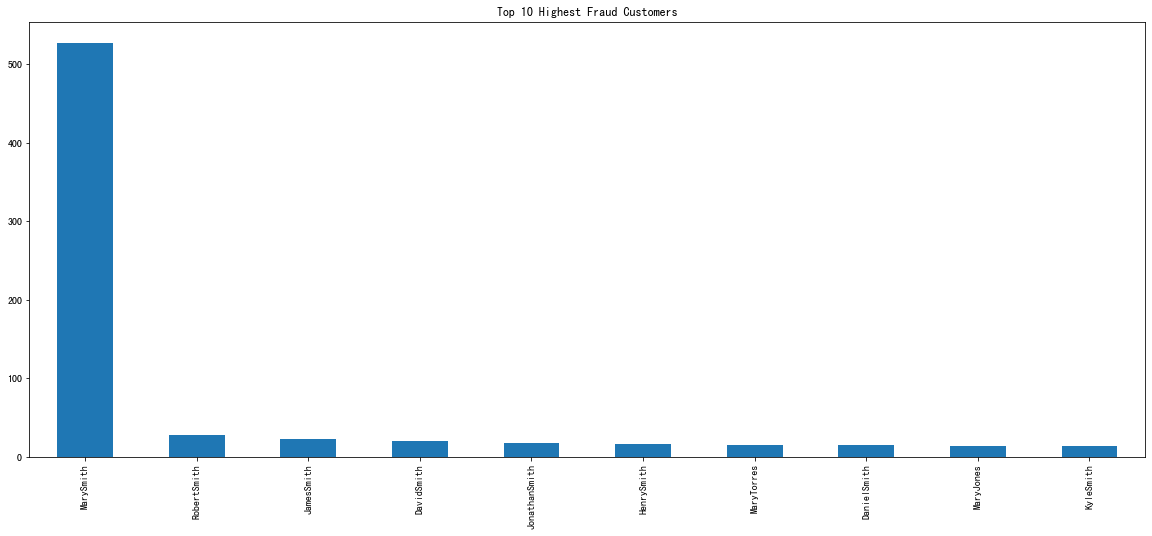

In [38]:
# 筛选出 Top10 Customer(风险)
cus = data[data['Order Status'] == 'SUSPECTED_FRAUD']
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20, 8), title = 'Top 10 Highest Fraud Customers')

In [39]:
print(data[data['Customer Full Name'] == 'MarySmith']['Sales'].sum())
print(data[(data['Customer Full Name'] == 'MarySmith') & (data['Order Status'] == 'SUSPECTED_FRAUD')]['Sales'].sum())

4771645.883297398
102491.66191043999


In [40]:
import pickle
with open('data.pkl', 'wb') as file:
    pickle.dump(data, file)